## Acoustic Impedance Estimation from Seismic Data Using Machine Learning in Well-Log Resolution

Rock properties estimation are always challenging part of geoscientific tasks but rewarding if it goes in right direction. Acoustic impedance(AI) is the product of sound wave velocity and medium density. In general, rocks with lower density (lower seismic wave velocity) tend to have higher porosity which can be host of fluids, attractive for hydrocarbon resource exploration. Conventionally, impedance can be estimated through inverse theory application but in this practice.

In this research, we will try to predict AI as continuous value. Attributes that we will use as input should be vintages from seismic data becuase we want to build a model that would be able to predict AI in all area of interest that have seismic coverage. 

In this work, we implemented basic regration prediction with TensorFlow using keras similarly to that of fuel efficiency:
https://www.tensorflow.org/tutorials/keras/regression

#### Library imports

In [1]:
# Use seaborn for pairplot
#!pip install -q seaborn

# Use some functions from tensorflow_docs
#!pip install -q git+https://github.com/tensorflow/docs

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

###  Reading data from excel file


This is very well-cleared data that we have an access. It is from three wells combined. From 3D seismic data, attributes are extracted in well location. In fact, we are working with 1D time/depth series data.

In [5]:
# use r before file address from hard disk location 
raw_dataset = pd.read_excel(r"E:\Data_Science\Projects\01_Regre_AI_estimation\data.xlsx", 
                          na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

Let's make a copy from pandas data base and see what we have inside data

In [6]:
dataset = raw_dataset.copy()
dataset.head()

,DEPT,TWT,amp,AI_Log,Int,D2,Quadr,TraceGrad,GradMag,Freq,Phase,CosPhase,AI_HRS_inv
0,1586.0760,1158.466797,2360.588623,8896.472656,2.582302,-966.705261,-121.763512,-166.771164,581.636291,51.744888,-2.980368,0.955099,NaN
1,1586.2284,1158.560791,2363.764648,8589.189648,2.567948,-957.876343,-45.403309,-186.041672,569.189453,51.807701,-1.254078,0.960877,NaN
2,1586.3808,1158.654663,2366.939941,8321.020684,2.553593,-949.047974,30.958862,-205.313339,556.743408,51.870518,0.472227,0.966654,NaN
3,1586.5332,1158.748657,2370.114990,8080.620275,2.539240,-940.220093,107.323006,-224.586151,544.298096,51.933334,2.198548,0.972431,NaN
4,1586.6856,1158.842529,2373.289307,7828.128756,2.524887,-931.392822,183.689117,-243.860107,531.853638,51.996155,3.924883,0.978207,NaN


### Data Explanation

Dataset has 13 columns as:  
__DEPT__: depth in meter  
__amp__ : seismic trace amplitude in well location  
__AI_log__: Acoustic Impedance calculated from well logs including sonic and Density  
The rest of columns are seismic attributes. You may read the detail of 5 attributes that we used as input for training. You may refer to _Barnes, A. E., 2016, Handbook of poststack seismic attributes: SEG Geophysical Reference Series 21_ for more attributes and details.  

  __D2__: Second derivative, it is the second time derivative of the input seismic volume. This can work as helpful tools for interpreters in the places where continuity is poorly resolved on raw amplitude profiles  
__Quadr__: Quadrature amplitude, this attribute is the imaginary part of the analytic signal, which is calculated by phase shifting the original trace by 90 degrees. An analytic signal can be generated from the real seismic amplitude and the imaginary quadrature amplitude  
__TraceGrad__: Trace gradient, the gradient along the trace is calculated. It will have the highest values where the greatest changes are happening  
__GradMag__:Gradient magnitude, the magnitude of instantaneous gradient is computed in 3-dimention employing neighbor traces  
__Freq__: Instantaneous frequency, it is the time derivative of phase angle and different from wavelet frequency. Commonly is used to estimate seismic attenuation. It can show cyclicity of geological features to assist interpretation. Reservoir oil and gas fluids may cause drop-off of high frequency components.  
__AI_HRS_inv__: Acoustic Impedance inversion(Band-limited) results from well logs and 3D seismic cube in well place


### Data cleaning

In [7]:
# see unknown values
dataset.isna().sum()

DEPT              0
TWT               0
amp               0
AI_Log            0
Int               0
D2                0
Quadr             0
TraceGrad         0
GradMag           0
Freq              0
Phase             0
CosPhase          0
AI_HRS_inv    10269
dtype: int64

Seismic inversion has been implemented in reservoir intervals, so we have to get rid of non-reservoir layers data from dataset.

In [8]:
#delete row with no data
dataset = dataset.dropna()
dataset.shape

(5193, 13)

### Data spliting

Before spliting dataset into train and test set, it is better to chose input and target columns as new dataframe. Based on try and error, these five attributes are chosen for training input. You may try others in order to find better reults.

In [9]:
train_dataset = dataset[["AI_Log", "D2","Quadr",  "TraceGrad","GradMag", "Freq"]]
test_dataset =dataset[["AI_Log","D2", "Quadr", "TraceGrad","GradMag", "Freq"]]

train_dataset = train_dataset.sample(frac=0.8, random_state=0)
test_dataset = test_dataset.drop(train_dataset.index)

In [10]:
test_dataset.tail()

,AI_Log,D2,Quadr,TraceGrad,GradMag,Freq
12303,9786.007257,566.524780,-1427.320923,216.984344,920.695312,27.043356
12305,9820.245703,547.678833,-1527.378784,224.735031,955.204102,27.043072
12306,10278.345351,538.253540,-1577.403442,228.611328,972.458679,27.042929
12311,10585.301989,491.100586,-1827.526733,248.012680,1058.748047,27.042217
12317,9459.522846,444.617859,-2059.946045,277.046661,1139.562256,26.992062


### Data inspection & visualization

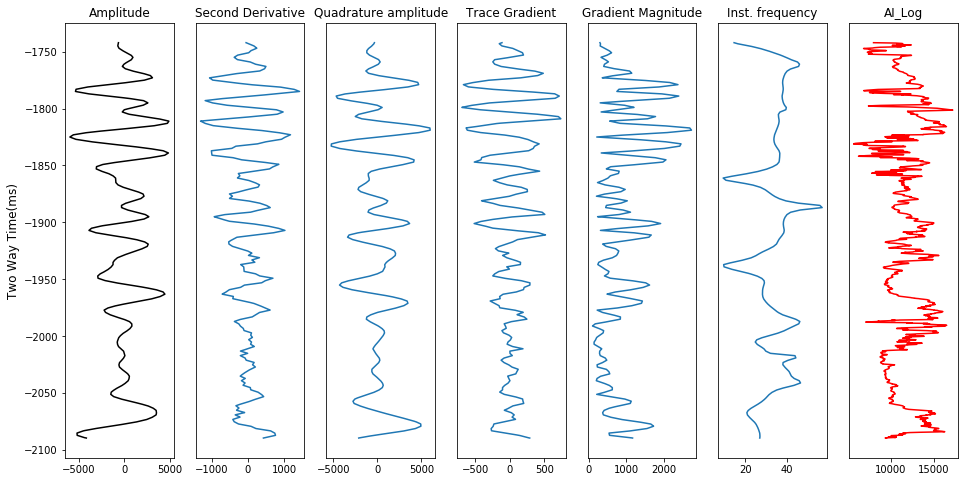

In [11]:
%matplotlib inline
# Geoscientists mainly are convinent with zero on surface
y = -(dataset['TWT'] )

plt.figure(figsize=(16,8) )

plt.subplot(1,7,1)
plt.plot(dataset["amp"], y, 'black')
plt.title("Amplitude")
plt.ylabel("Two Way Time(ms)", fontsize = 12)

plt.subplot(1,7,2)
plt.plot(dataset["D2"], y)
plt.title("Second Derivative")
plt.yticks([])

plt.subplot(1,7,3)
plt.plot(dataset["Quadr"], y)
plt.title("Quadrature amplitude")
plt.yticks([])

plt.subplot(1,7,4)
plt.plot(dataset["TraceGrad"], y)
plt.title("Trace Gradient")
plt.yticks([])

plt.subplot(1,7,5)
plt.plot(dataset["GradMag"], y)
plt.title("Gradient Magnitude")
plt.yticks([])

plt.subplot(1,7,6)
plt.plot(dataset["Freq"], y)
plt.title("Inst. frequency")
plt.yticks([])

plt.subplot(1,7,7)
plt.plot(dataset["AI_Log"], y, 'red')
plt.title("AI_Log")
plt.yticks([])

# plt.show()
plt.savefig("fig1.png", dpi=300)

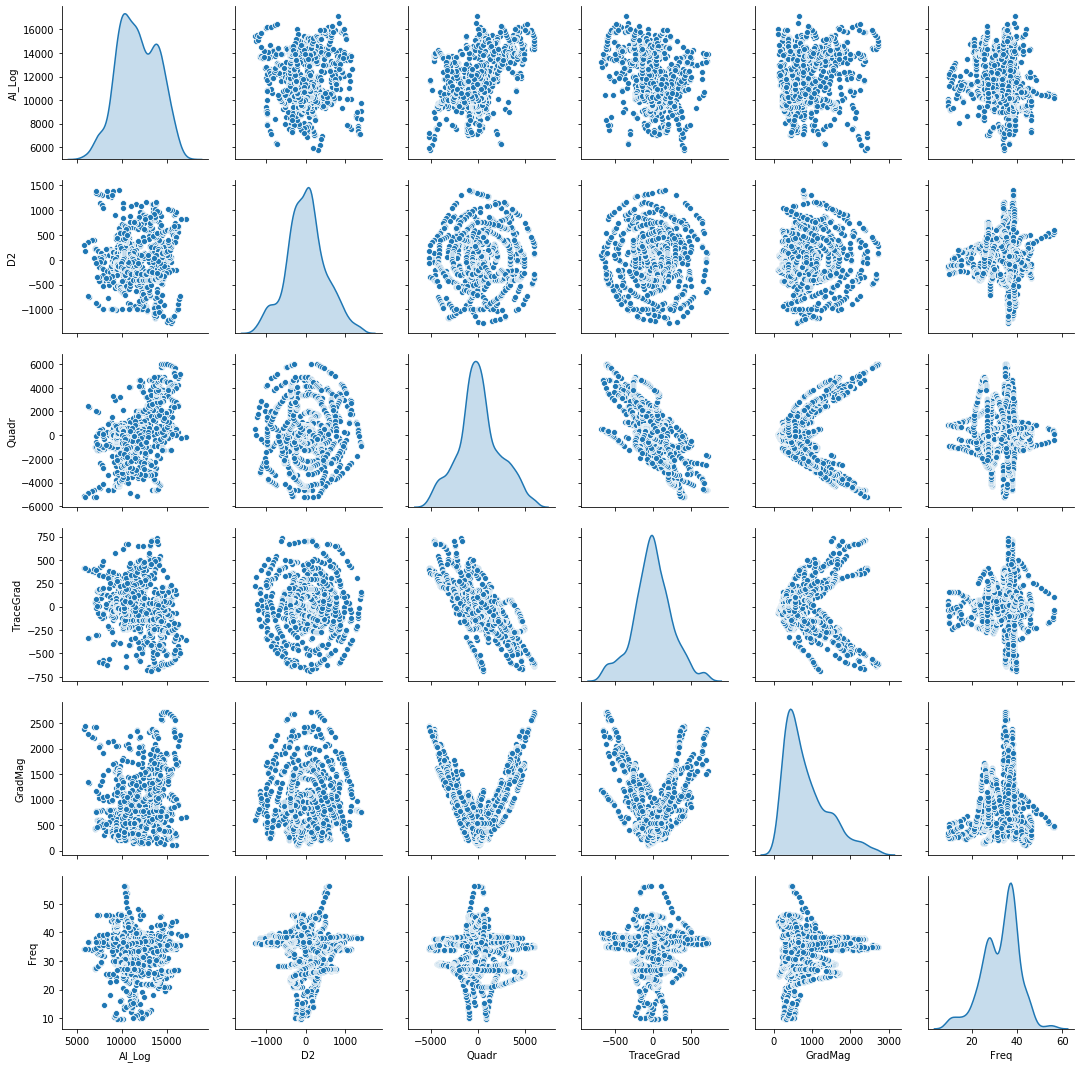

In [12]:
sns.pairplot(test_dataset[["AI_Log", "D2","Quadr", "TraceGrad","GradMag", "Freq"]], diag_kind='kde') 

Let's look at some statistical feature of data that we want to input in training set

In [13]:
train_stats = train_dataset.describe()
train_stats.pop("AI_Log")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
D2,4154.0,6.233901,483.644848,-1301.850220,-269.884384,0.937068,287.638557,1426.181519
Quadr,4154.0,68.946043,2222.350184,-5258.812012,-1135.513886,-83.835155,1076.680450,6001.270996
TraceGrad,4154.0,-1.895277,261.936301,-692.938904,-146.534729,-10.918543,157.479198,737.373962
GradMag,4154.0,852.799978,580.266098,104.631599,417.605415,653.331024,1130.101135,2719.670166
Freq,4154.0,33.217643,8.299750,9.398151,28.239159,35.046831,38.467464,56.897087


Seperate target values(here AI is our target) from dataset

In [14]:
train_labels = train_dataset.pop('AI_Log')
test_labels = test_dataset.pop('AI_Log')

### Data normalize

In neural network training, normalization will help network efficiency.

In [15]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [16]:
normed_test_data.head()

,D2,Quadr,TraceGrad,GradMag,Freq
7127,-0.110911,-0.186294,-0.423878,-0.951503,-2.239415
7134,-0.033997,-0.197319,-0.512131,-0.936389,-2.139127
7148,0.116923,-0.237370,-0.536117,-0.929738,-1.854823
7151,0.148651,-0.248342,-0.521002,-0.931481,-1.782884
7152,0.159211,-0.251999,-0.515962,-0.932060,-1.758911


### Modeling

To build a model, Sequential type is used here with two densley hidden layers. The output layer is single value which is AI.

In [17]:
def build_model():
  model = keras.Sequential([
    layers.Dense(500, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(400, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.01) 

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [18]:
model = build_model()

Inspecting model:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 203,801
Trainable params: 203,801
Non-trainable params: 0
_________________________________________________________________


Toexamine that model is working properly, we can use batch of 10 from training data and see the predition

In [20]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.01107395],
       [-0.11585939],
       [-0.05931292],
       [-0.01615195],
       [ 0.01812955],
       [-0.09842154],
       [-0.02744032],
       [-0.03029541],
       [-0.06482209],
       [-0.04807144]], dtype=float32)

### Train the model

In [21]:
EPOCHS = 800 # number of iteration

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:20326672.5637,  mae:2999.0039,  mse:20326670.0000,  val_loss:3400151.6429,  val_mae:1412.1841,  val_mse:3400151.7500,  
....................................................................................................
Epoch: 100, loss:731544.6827,  mae:653.6818,  mse:731544.6875,  val_loss:597300.7438,  val_mae:581.8657,  val_mse:597300.6875,  
....................................................................................................
Epoch: 200, loss:426562.7463,  mae:503.4432,  mse:426562.7812,  val_loss:898524.2260,  val_mae:765.0529,  val_mse:898524.1875,  
....................................................................................................
Epoch: 300, loss:281464.6217,  mae:402.2661,  mse:281464.5938,  val_loss:258756.7284,  val_mae:382.7484,  val_mse:258756.7344,  
....................................................................................................
Epoch: 400, loss:196574.8761,  mae:331.9235,  mse:196574.8594,  val_loss:

Lets see model training progress.

In [22]:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
795,98258.490725,231.870895,98258.476562,115567.226327,265.341858,115567.210938,795
796,94248.819868,226.598312,94248.812500,166171.506242,304.805878,166171.515625,796
797,97778.097074,232.587463,97778.085938,106014.906175,241.120529,106014.906250,797
798,90528.221460,226.929932,90528.210938,99104.203078,221.760010,99104.195312,798
799,90566.721329,224.955505,90566.734375,142615.867225,306.086731,142615.890625,799


#### Plotting model progress

In [23]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [AI_Log]')

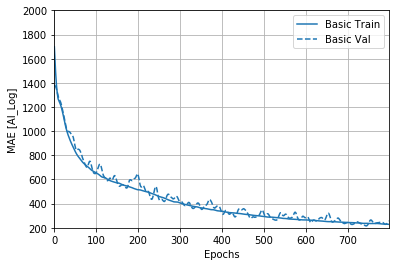

In [24]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([200, 2000])
#plt.xlim([0, 200])
plt.ylabel('MAE [AI_Log]')

Training curve shows that if iteration set to higher values, data convergence will continue. We need to consider that forcing model down to very small error values will cuase overfitting as well as longer calulation time. Chosing the appropriate epoch is depends on what we expect from the model. There must be trade off between model accuracy and calculation cost.  

Text(0, 0.5, 'MSE [AI_Log]')

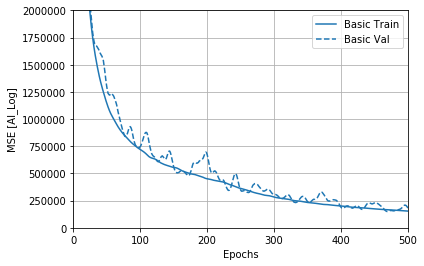

In [25]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 2000000])
plt.xlim([0, 500])
plt.ylabel('MSE [AI_Log]')

These graphs show that after initial iterations, the validation error are not improved importantly. In fact, training rate is not very steep, so its better to consider some function to limit iteration for time saving.  
We may let the model to fit better with more iteration cycle but it will have overfitting challenges.

In [26]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:20608742.1801,  mae:3016.9587,  mse:20608740.0000,  val_loss:3296653.9001,  val_mae:1407.7926,  val_mse:3296654.0000,  
....................................................................................................
Epoch: 100, loss:671730.8177,  mae:635.6545,  mse:671730.8125,  val_loss:537249.1032,  val_mae:538.5933,  val_mse:537249.1250,  
.

Text(0, 0.5, 'MAE [AI]')

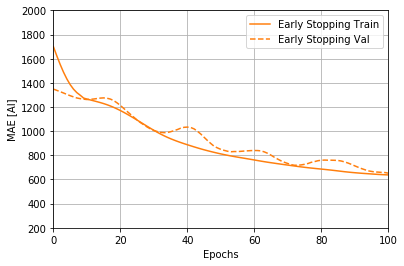

In [27]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([200, 2000])
plt.ylabel('MAE [AI]')
#plt.savefig("fig2.png", dpi=300)

#### model check with test data

In [28]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} AI".format(mae))

1039/1039 - 0s - loss: 532508.7424 - mae: 550.9574 - mse: 532508.7500
Testing set Mean Abs Error: 550.96 AI


MAE value for this model evaluation is about 500. It is acceptable becuase AI ranges from 5000 to 15000 in this dataset.

#### Prediction

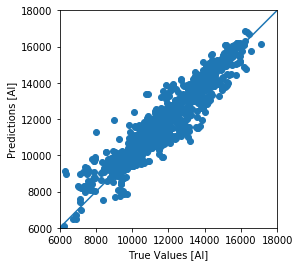

In [29]:

test_predictions = model.predict(normed_test_data).flatten()

a = plt.figure()
a = plt.axes(aspect='equal')
a = plt.scatter(test_labels, test_predictions)
a =plt.xlabel('True Values [AI]')
a = plt.ylabel('Predictions [AI]')
a = lims = [6000, 18000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
#plt.savefig("fig4.png", dpi=600)

In [50]:
from sklearn.metrics import r2_score
r2_score(test_labels, test_predictions)

0.8874245391669886

In [30]:
test_dataset

,D2,Quadr,TraceGrad,GradMag,Freq
7127,-47.407486,-345.064606,-112.924370,300.675049,14.631061
7134,-10.208574,-369.565308,-136.040955,309.445160,15.463427
7148,62.783119,-458.574005,-142.323761,313.304352,17.823076
7151,78.128311,-482.956726,-138.364716,312.293304,18.420151
7152,83.235641,-491.084625,-137.044571,311.957245,18.619120
...,...,...,...,...,...
12303,566.524780,-1427.320923,216.984344,920.695312,27.043356
12305,547.678833,-1527.378784,224.735031,955.204102,27.043072
12306,538.253540,-1577.403442,228.611328,972.458679,27.042929
12311,491.100586,-1827.526733,248.012680,1058.748047,27.042217


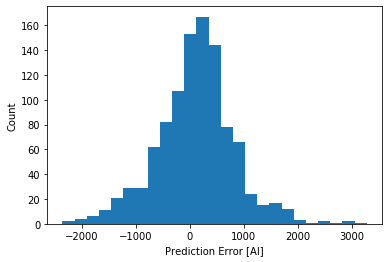

In [31]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [AI]")
_ = plt.ylabel("Count")
#plt.savefig("fig5.png", dpi=600)

### AI comparison of real, predicted and band-limited inversion results

For plotting purpose to se how AI from inversion is diffrent from ML prediction, we make the same dataset and similar data splitting previously

In [47]:
train_dataset1 = dataset[["AI_HRS_inv"]]
test_dataset1 =dataset[["AI_HRS_inv"]]
train_dataset1 = train_dataset1.sample(frac=0.8, random_state=0)
test_dataset1 = test_dataset1.drop(train_dataset1.index)

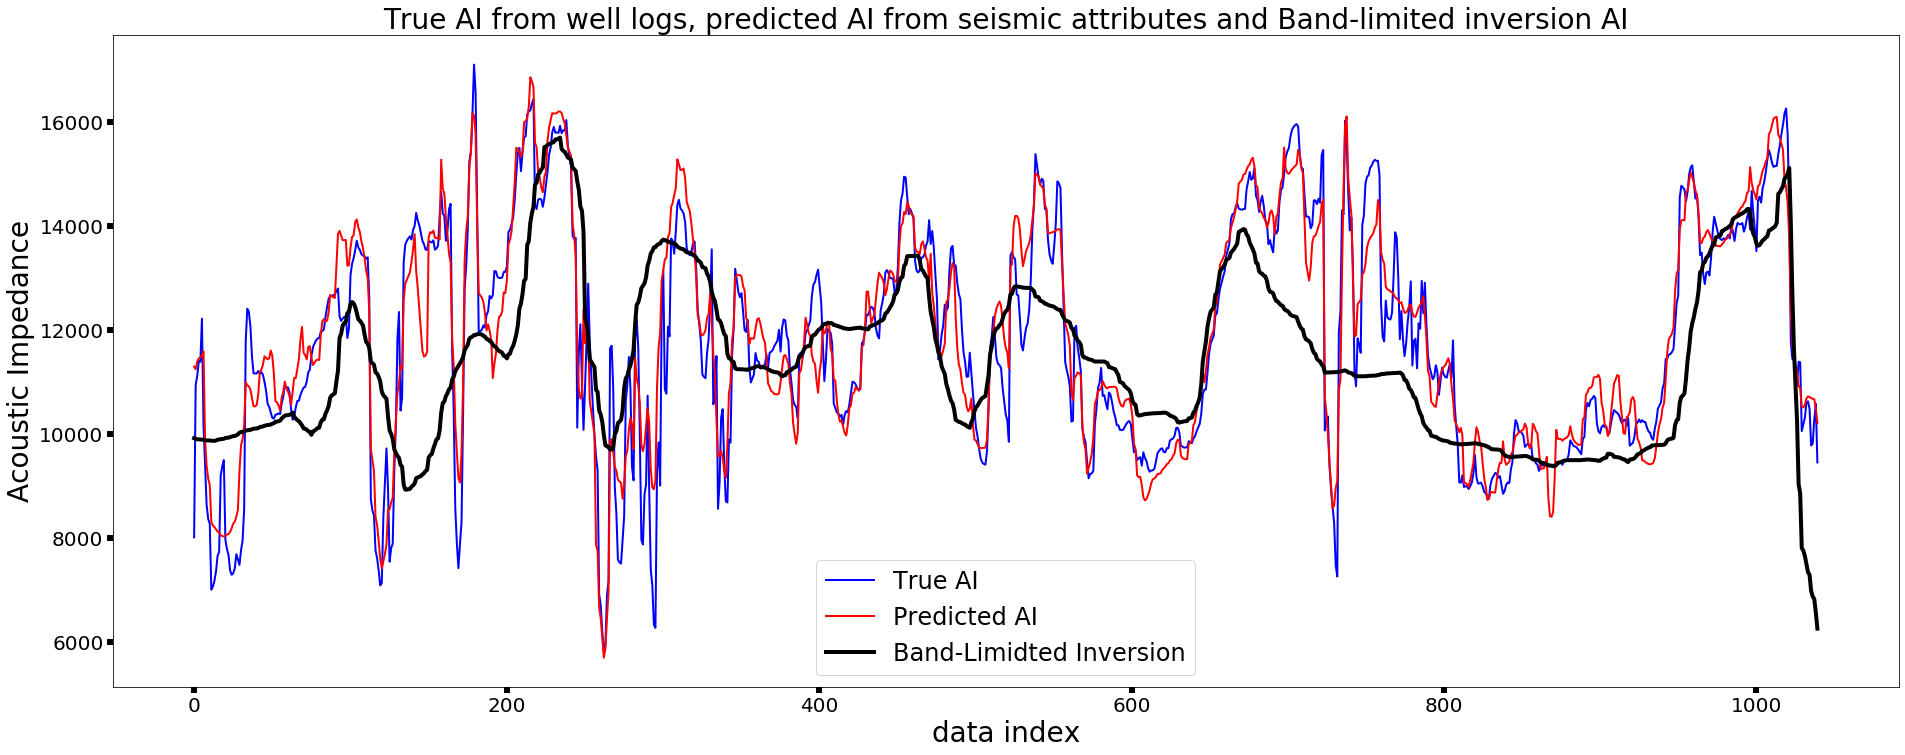

In [75]:

plt.figure(figsize = (32,12))
x = np.linspace(0,len(test_dataset1),len(test_dataset1))

plt.plot(x,test_labels, linewidth=2, color="blue")
plt.plot(x,test_predictions, linewidth=2, color="red")
plt.plot(x,test_dataset1["AI_HRS_inv"], color='black', linewidth=4)
plt.title("True AI from well logs, predicted AI from seismic attributes and Band-limited inversion AI", fontsize = 28)
plt.ylabel('Acoustic Impedance', fontsize = 28)
plt.xlabel('data index', fontsize =28)
plt.tick_params(direction='out', length=6, width=6, labelsize=20)
plt.legend(["True AI","Predicted AI", "Band-Limidted Inversion"], fontsize=24)
#plt.show()

plt.savefig("fig6.png", dpi=300)

Predicted and real AI are plotted in reservoir intervals in well place. The trend and values show strong agreement. Band limited inversion impedance is also plotted to see how it follows the property variation through the depth. Overall, it shows appropriate trend adaptation but for local variation it does not have enough ability to extract the same resolution.

Machine learning can be beneficial in reservoir rock properties estimation such as impedance. It is possible to reach AI variations in well log resolution from surface seismic data and its vintages. Computationally, it can be heavy and expensive if we select complicated network architecture.

